In [2]:
import numpy as np 
import pandas as pd
import neattext.functions as nfx
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tqdm import tqdm
import pickle


In [3]:
data=pd.read_csv('./dataset/Suicide_Detection.csv')
data.drop(['Unnamed: 0'], axis=1,inplace=True)

In [4]:
train_data,test_data=train_test_split(data,test_size=0.2,random_state=10)

In [5]:
def clean_text(text):
    text_length=[]
    cleaned_text=[]
    for str in tqdm(text):
        str=str.lower()
        # str=nfx.remove_emails(str)
        # str=nfx.remove_urls(str)
        str=nfx.remove_special_characters(str)
        str=nfx.remove_stopwords(str)
        text_length.append(len(str.split()))
        cleaned_text.append(str)
    return cleaned_text,text_length

In [6]:
cleaned_train_text, train_text_length = clean_text(train_data.text)
cleaned_test_text, test_text_length = clean_text(test_data.text)

100%|██████████| 46415/46415 [00:01<00:00, 29399.48it/s]


In [7]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(cleaned_train_text)

word_frequency = pd.DataFrame(tokenizer.word_counts.items(),columns=['word','count']).sort_values(by='count',ascending=False)
print(word_frequency)

                  word   count
35                  im  261569
21                dont  170560
8                 like  143810
29                want  118837
28                know  103925
...                ...     ...
138279       startonce       1
138280        leafless       1
138281       branchesa       1
138282  wolverinestyle       1
271867          roomin       1

[271868 rows x 2 columns]


# Process Text For the Model

In [8]:
train_text_seq= tokenizer.texts_to_sequences(cleaned_train_text)
train_text_pad= pad_sequences(train_text_seq,maxlen=40)

test_text_seq= tokenizer.texts_to_sequences(cleaned_test_text)
test_text_pad= pad_sequences(test_text_seq,maxlen=40)

In [9]:
lbl_target=LabelEncoder()
train_output=lbl_target.fit_transform(train_data['class'])
test_output=lbl_target.transform(test_data['class'])

# Embedding Model 

In [10]:
with open('./dataset/glove.840B.300d.pkl', 'rb') as fp:
    glove = pickle.load(fp)

In [11]:
dataset_length=len(tokenizer.word_index)

embedding_matrix=np.zeros((dataset_length+1,300), dtype=float) #pad 0 to prep the matrix to match with the shape of our dataset
for word,i in tokenizer.word_index.items():
    num = glove.get(word)
    if num is not None:
        embedding_matrix[i] = num

# Model Building

inputs = keras.Input(shape=(40,))
h1 = keras.layers.Embedding(dataset_length+1, 300, weights=[embedding_matrix],trainable=False)(inputs)
h2 = keras.layers.LSTM(20,return_sequences=True)(h1)
h3 = keras.layers.GlobalMaxPooling1D()(h2)
h4 = keras.layers.Dense(256,activation=tf.nn.relu)(h3)
outputs = keras.layers.Dense(1,activation=tf.nn.sigmoid)(h4)
model = keras.Model(inputs=inputs, outputs=outputs, name="suicide_risk_model")

model.summary()

In [13]:
model=tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(40,)))
model.add(tf.keras.layers.Embedding(dataset_length+1,300,weights=[embedding_matrix],trainable=False))
model.add(tf.keras.layers.LSTM(20,return_sequences=True))
model.add(tf.keras.layers.GlobalMaxPooling1D())
#     model.add(Dropout(0.3))
model.add(tf.keras.layers.Dense(256,activation='relu'))
#     model.add(Dropout(0.2))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
model.compile(optimizer=keras.optimizers.SGD(0.1,momentum=0.09),loss='binary_crossentropy',metrics=['accuracy'])

In [14]:
optimizer = keras.optimizers.SGD(learning_rate=0.1, momentum=0.09)
early_break = EarlyStopping(monitor='loss', patience=5)
reduce_learning_rate = ReduceLROnPlateau(patience=3)

model.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

r=model.fit(train_text_pad,train_output,validation_data=(test_text_pad,test_output),
            epochs=20,batch_size=256,callbacks=[early_break,reduce_learning_rate])

Epoch 1/20


c:\Users\Frankie\Desktop\Project\Health-Assistant\myenv\lib\site-packages\keras\backend.py:5673: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


726/726 [==============================] - 18s 23ms/step - loss: 0.3461 - accuracy: 0.8584 - val_loss: 0.2648 - val_accuracy: 0.8937 - lr: 0.1000
Epoch 2/20
726/726 [==============================] - 19s 26ms/step - loss: 0.2517 - accuracy: 0.8986 - val_loss: 0.2580 - val_accuracy: 0.8940 - lr: 0.1000
Epoch 3/20
726/726 [==============================] - 18s 25ms/step - loss: 0.2339 - accuracy: 0.9066 - val_loss: 0.2543 - val_accuracy: 0.8984 - lr: 0.1000
Epoch 4/20
726/726 [==============================] - 18s 25ms/step - loss: 0.2222 - accuracy: 0.9120 - val_loss: 0.2600 - val_accuracy: 0.8941 - lr: 0.1000
Epoch 5/20
726/726 [==============================] - 18s 25ms/step - loss: 0.2120 - accuracy: 0.9168 - val_loss: 0.2092 - val_accuracy: 0.9190 - lr: 0.1000
Epoch 6/20
726/726 [==============================] - 18s 25ms/step - loss: 0.2010 - accuracy: 0.9215 - val_loss: 0.2016 - val_accuracy: 0.9209 - lr: 0.1000
Epoch 7/20
726/726 [==============================] - 19s 26ms/step -

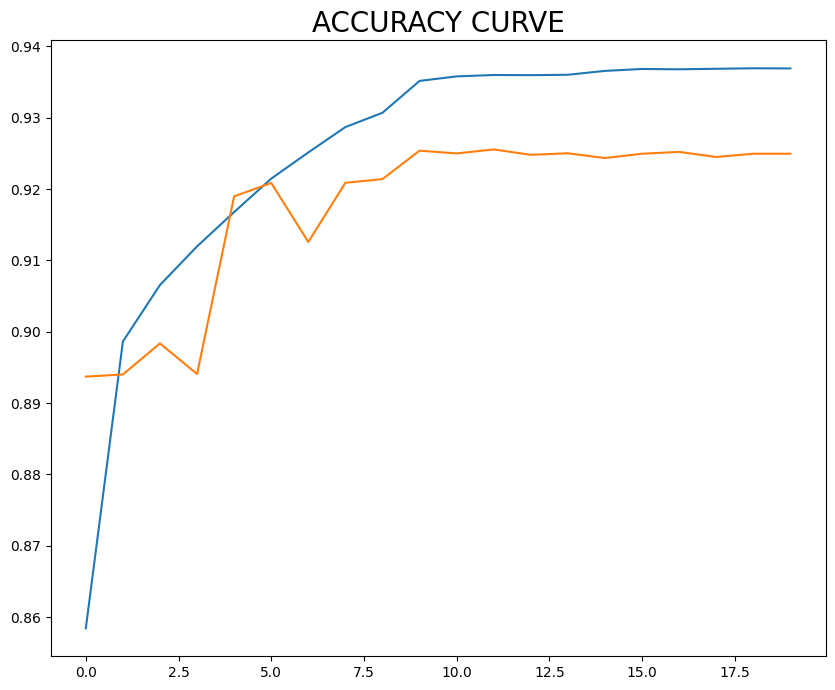

In [15]:
plt.figure(figsize=(10,8))
plt.plot(r.history['accuracy'])
plt.plot(r.history['val_accuracy'])
plt.title('ACCURACY CURVE',fontdict={'size':20})
plt.show()

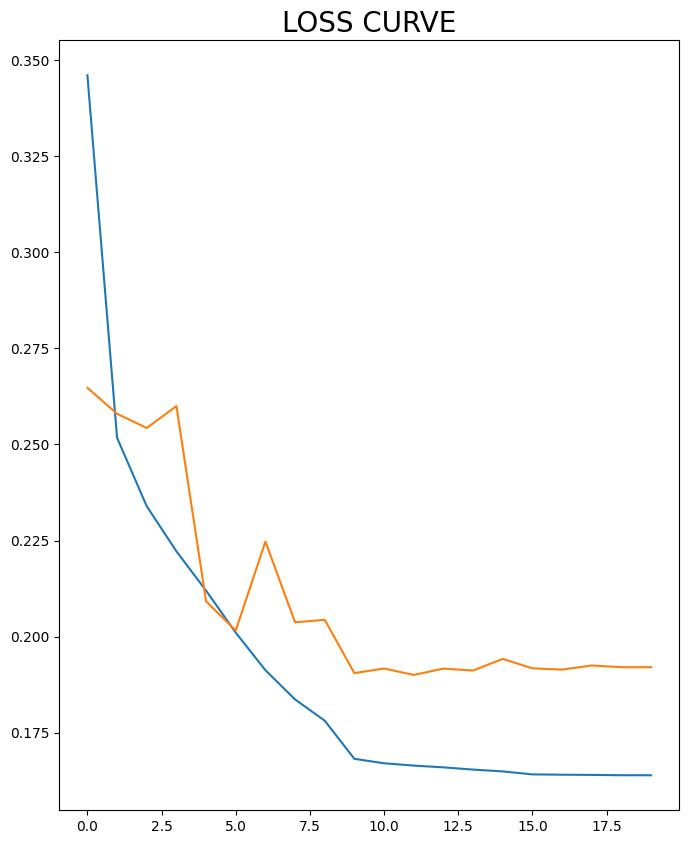

In [16]:
plt.figure(figsize=(8,10))
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.title('LOSS CURVE',fontdict={'size':20})
plt.show()

In [17]:
model.save('./model',overwrite=True)

INFO:tensorflow:Assets written to: ./model\assets


INFO:tensorflow:Assets written to: ./model\assets
